In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Flattened image: (1000, 100)


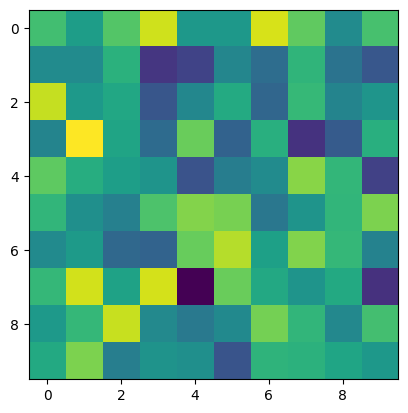

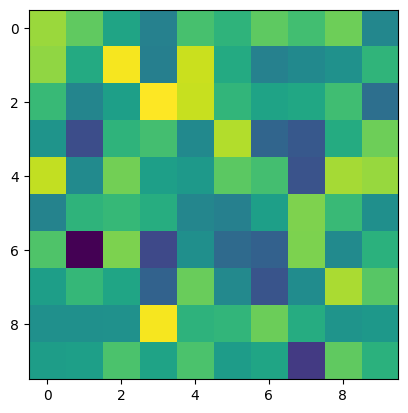

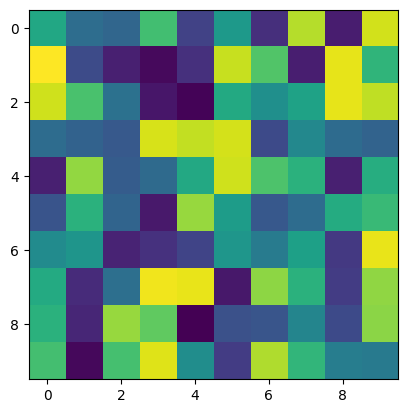

In [34]:
# Generate synthetic "images" (flattened to 1D for simplicity)
np.random.seed(42)

# Flattened 10x10 images
anomalous_images = np.concatenate([
    np.random.normal(loc=0.5, scale=0.1, size=(950, 100)),  # Normal
    np.random.uniform(low=0, high=1, size=(50, 100))        # Anomalies (random noise)
])

print(f"Flattened image: {anomalous_images.shape}")
plt.imshow(anomalous_images[0].reshape(10,10))
plt.show()
plt.imshow(anomalous_images[10].reshape(10,10))
plt.show()
plt.imshow(anomalous_images[998].reshape(10,10))
plt.show()

In [31]:
# Convert to PyTorch tensors
X = torch.FloatTensor(np.concatenate([anomalous_images]))

# Define AutoEncoder with linear layers
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=100, encoding_dim=10):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [32]:
# Initialize model, loss, and optimizer
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train on normal images only
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X[:950])
    loss = criterion(outputs, X[:950])
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

# Detect anomalies
with torch.no_grad():
    reconstructions = model(X)
    mse = torch.mean((X - reconstructions) ** 2, dim=1)




Epoch [10/100], Loss: 0.0102
Epoch [20/100], Loss: 0.0101
Epoch [30/100], Loss: 0.0100
Epoch [40/100], Loss: 0.0100
Epoch [50/100], Loss: 0.0100
Epoch [60/100], Loss: 0.0100
Epoch [70/100], Loss: 0.0100
Epoch [80/100], Loss: 0.0099
Epoch [90/100], Loss: 0.0099
Epoch [100/100], Loss: 0.0098


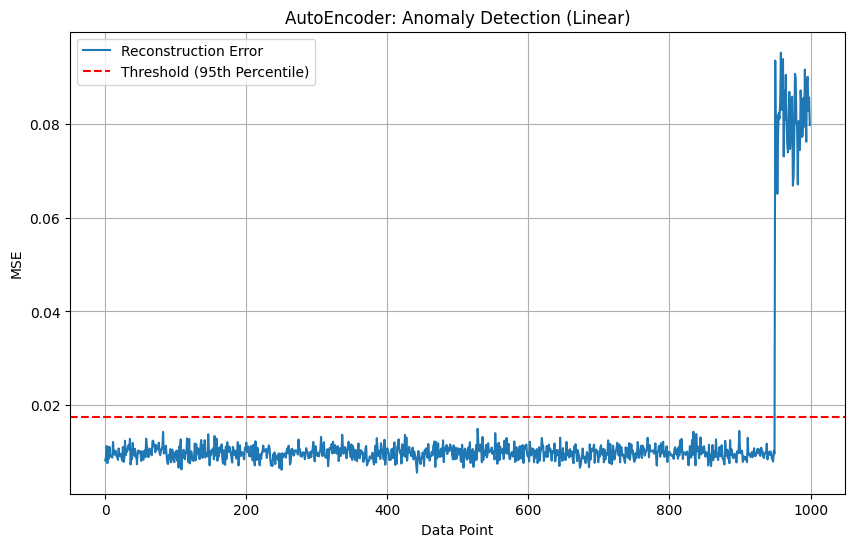

In [33]:
# Plot reconstruction error
plt.figure(figsize=(10, 6))
plt.plot(mse.numpy(), label="Reconstruction Error")
plt.axhline(y=np.percentile(mse.numpy(), 95), color='r', linestyle='--', label="Threshold (95th Percentile)")
plt.title("AutoEncoder: Anomaly Detection (Linear)")
plt.xlabel("Data Point")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()